# Figure 2:  SMYLE & DPLE Global Precipitation ACC Maps

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io
from SMYLEutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [37]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- The data loading steps can take ~30 minutes
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_midmonth(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [7]:
%%time
# SMYLE-NOV PRECT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PRECT'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
chunk = {}
smyle11_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle11_seas.nbytes/1e9 #GB

CPU times: user 39 s, sys: 19.2 s, total: 58.2 s
Wall time: 1min 5s


3.468172712

In [8]:
%%time
# SMYLE-FEB PRECT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PRECT'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
startmonth = 2
smyle02_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02_seas.nbytes/1e9 #GB

CPU times: user 39.4 s, sys: 19.1 s, total: 58.4 s
Wall time: 1min 3s


3.468172712

In [9]:
%%time
# SMYLE-MAY PRECT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PRECT'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
startmonth = 5
smyle05_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05_seas.nbytes/1e9 #GB

CPU times: user 39.3 s, sys: 19.2 s, total: 58.5 s
Wall time: 1min 4s


3.468172712

In [10]:
%%time
# SMYLE-AUG PRECT data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PRECT'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
startmonth = 8
smyle08_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08_seas.nbytes/1e9 #GB

CPU times: user 40.9 s, sys: 19 s, total: 60 s
Wall time: 1min 5s


3.468172712

In [11]:
%%time
# DPLE-NOV PRECT data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'PRECT'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
dple11_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
dple11_seas.nbytes/1e9 #GB

CPU times: user 19.7 s, sys: 3.07 s, total: 22.7 s
Wall time: 29.6 s


6.79478016

### Regrid Hindcast data

In [5]:
## Define 5x5 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,95,5),'lon':np.arange(0,360,5)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [13]:
dple11_seas = regrid.add_grid_bounds(dple11_seas)
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle02_seas = regrid.add_grid_bounds(smyle02_seas)
smyle05_seas = regrid.add_grid_bounds(smyle05_seas)
smyle08_seas = regrid.add_grid_bounds(smyle08_seas)

In [14]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(dple11_seas, destgrid, 'conservative', periodic=True)

In [15]:
%%time
dple11_da = regrid_cam1deg(dple11_seas.PRECT).load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 2min 9s, sys: 18.7 s, total: 2min 27s
Wall time: 2min 33s


In [16]:
%%time
smyle11_da = regrid_cam1deg(smyle11_seas.PRECT).load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 1min 2s, sys: 8.57 s, total: 1min 11s
Wall time: 1min 14s


In [17]:
%%time
smyle02_da = regrid_cam1deg(smyle02_seas.PRECT).load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 1min 2s, sys: 8.58 s, total: 1min 10s
Wall time: 1min 14s


In [18]:
%%time
smyle05_da = regrid_cam1deg(smyle05_seas.PRECT).load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 1min, sys: 8.56 s, total: 1min 8s
Wall time: 1min 11s


In [19]:
%%time
smyle08_da = regrid_cam1deg(smyle08_seas.PRECT).load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 1min 3s, sys: 8.31 s, total: 1min 11s
Wall time: 1min 14s


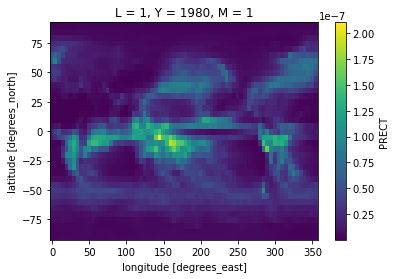

In [20]:
smyle11_da.isel(Y=10,L=0,M=0).plot();

In [22]:
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
ds1 = dple11_da.to_dataset()
ds1['time'] = dple11_seas.time
ds1.to_netcdf(outdir+'DPLE11_PRE_seas_5x5.nc')

ds1 = smyle11_da.to_dataset()
ds1['time'] = smyle11_seas.time
ds1.to_netcdf(outdir+'SMYLE11_PRE_seas_5x5.nc')

ds1 = smyle02_da.to_dataset()
ds1['time'] = smyle02_seas.time
ds1.to_netcdf(outdir+'SMYLE02_PRE_seas_5x5.nc')

ds1 = smyle05_da.to_dataset()
ds1['time'] = smyle05_seas.time
ds1.to_netcdf(outdir+'SMYLE05_PRE_seas_5x5.nc')

ds1 = smyle08_da.to_dataset()
ds1['time'] = smyle08_seas.time
ds1.to_netcdf(outdir+'SMYLE08_PRE_seas_5x5.nc')

In [6]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas = xr.open_dataset(outdir+'DPLE11_PRE_seas_5x5.nc')
dple11_da = dple11_seas['PRECT']
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_PRE_seas_5x5.nc')
smyle11_da = smyle11_seas['PRECT']
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_PRE_seas_5x5.nc')
smyle02_da = smyle02_seas['PRECT']
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_PRE_seas_5x5.nc')
smyle05_da = smyle05_seas['PRECT']
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_PRE_seas_5x5.nc')
smyle08_da = smyle08_seas['PRECT']

### Get precip OBS

In [7]:
# CRU TS4.05  (0.5deg PRE over land)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_cru = xr.open_dataset(obs_dir+'mon/PRE/cru_ts4.05.1901.2020.pre.dat.nc',decode_times=False)
cru_montime_vals = [cftime.DatetimeNoLeap(1901+year, 1+month, 15) for year in range(120) for month in range(12)]
ds_cru['time'] = cru_montime_vals
ds_cru = ds_cru.sel(time=slice("1960","2019"))

In [8]:
# convert mm/month to m/s
convfact = xr.DataArray(1/((1.e3)*(ds_cru.time.dt.days_in_month.values*24*60*60)),dims=['time'],coords={'time':ds_cru.time})
ds_cru['pre'] = ds_cru['pre']*convfact

In [9]:
# JRA55  (55-km global)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_jra55 = xr.open_dataset(obs_dir+'mon/PRE/PRE_JRA55_1958-2019.nc')
nt = np.size(ds_jra55.time)
jra55_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(62) for month in range(12)]
ds_jra55['time'] = jra55_montime_vals
ds_jra55 = ds_jra55.sel(time=slice("1960","2019"))

In [10]:
# convert kg/m^2/s to m/s
convfact = xr.DataArray(1/(1.e3),dims=['time'],coords={'time':ds_jra55.time})
ds_jra55['pr'] = ds_jra55['pr']*convfact

### Compute OBS seasonal averages

In [11]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [12]:
cru_seas = obs_convert_mon_to_seas(ds_cru.pre,'PRE').sel(year=slice("1960","2019"))
cru_seas = regrid.add_grid_bounds(cru_seas)

In [13]:
jra55_seas = obs_convert_mon_to_seas(ds_jra55.pr,'PRE').sel(year=slice("1960","2019"))
jra55_seas = regrid.add_grid_bounds(jra55_seas)

### Regrid & Merge PRE OBS

In [14]:
%%time
regrid_cru = xe.Regridder(cru_seas, destgrid, 'conservative', periodic=True)
cru_seas_rg = regrid_cru(cru_seas.PRE,skipna=True, na_thres=0.6)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 7.73 s, sys: 737 ms, total: 8.46 s
Wall time: 9.4 s


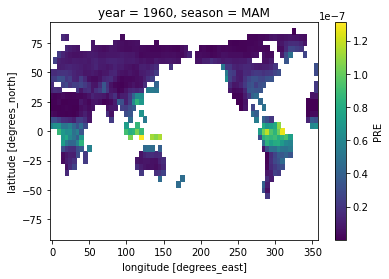

In [15]:
cru_seas_rg.isel(year=0,season=1).plot()

In [16]:
%%time
regrid_jra = xe.Regridder(jra55_seas, destgrid, 'conservative', periodic=True)
jra55_seas_rg = regrid_jra(jra55_seas.PRE,skipna=True, na_thres=0.9)

CPU times: user 1.35 s, sys: 118 ms, total: 1.47 s
Wall time: 1.54 s


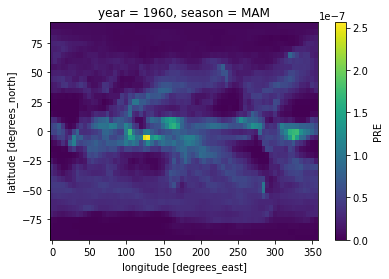

In [17]:
jra55_seas_rg.isel(year=0,season=1).plot()

In [18]:
def merge_obs(da1,da2):
    return da1.fillna(da2)

In [19]:
# merged CRU/JRA55 (but keep Antarctica masked)
crujra = merge_obs(cru_seas_rg,jra55_seas_rg)

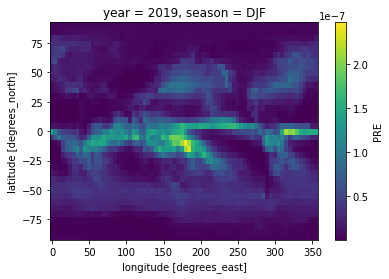

In [20]:
crujra.isel(season=0).sel(year=2019).plot();

In [21]:
## convert OBS to anomalies from 1972-2017
crujra = crujra - crujra.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [22]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11_da,smyle11_seas.time,1972,2017)
dple11_anom,dple11_clim = stat.remove_drift(dple11_da,dple11_seas.time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02_da,smyle02_seas.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05_da,smyle05_seas.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08_da,smyle08_seas.time,1972,2017)

CPU times: user 1.32 s, sys: 2.65 s, total: 3.97 s
Wall time: 4.95 s


In [23]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stat.leadtime_skill_seas_resamp(dple11_anom,dple11_seas.time,crujra,100,20)

CPU times: user 1min 5s, sys: 1.94 s, total: 1min 7s
Wall time: 1min 16s


In [24]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_seas.time,crujra)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_seas.time,crujra)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_seas.time,crujra)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_seas.time,crujra)

CPU times: user 2.13 s, sys: 127 ms, total: 2.26 s
Wall time: 2.37 s


CPU times: user 10.7 s, sys: 104 ms, total: 10.8 s
Wall time: 12.2 s


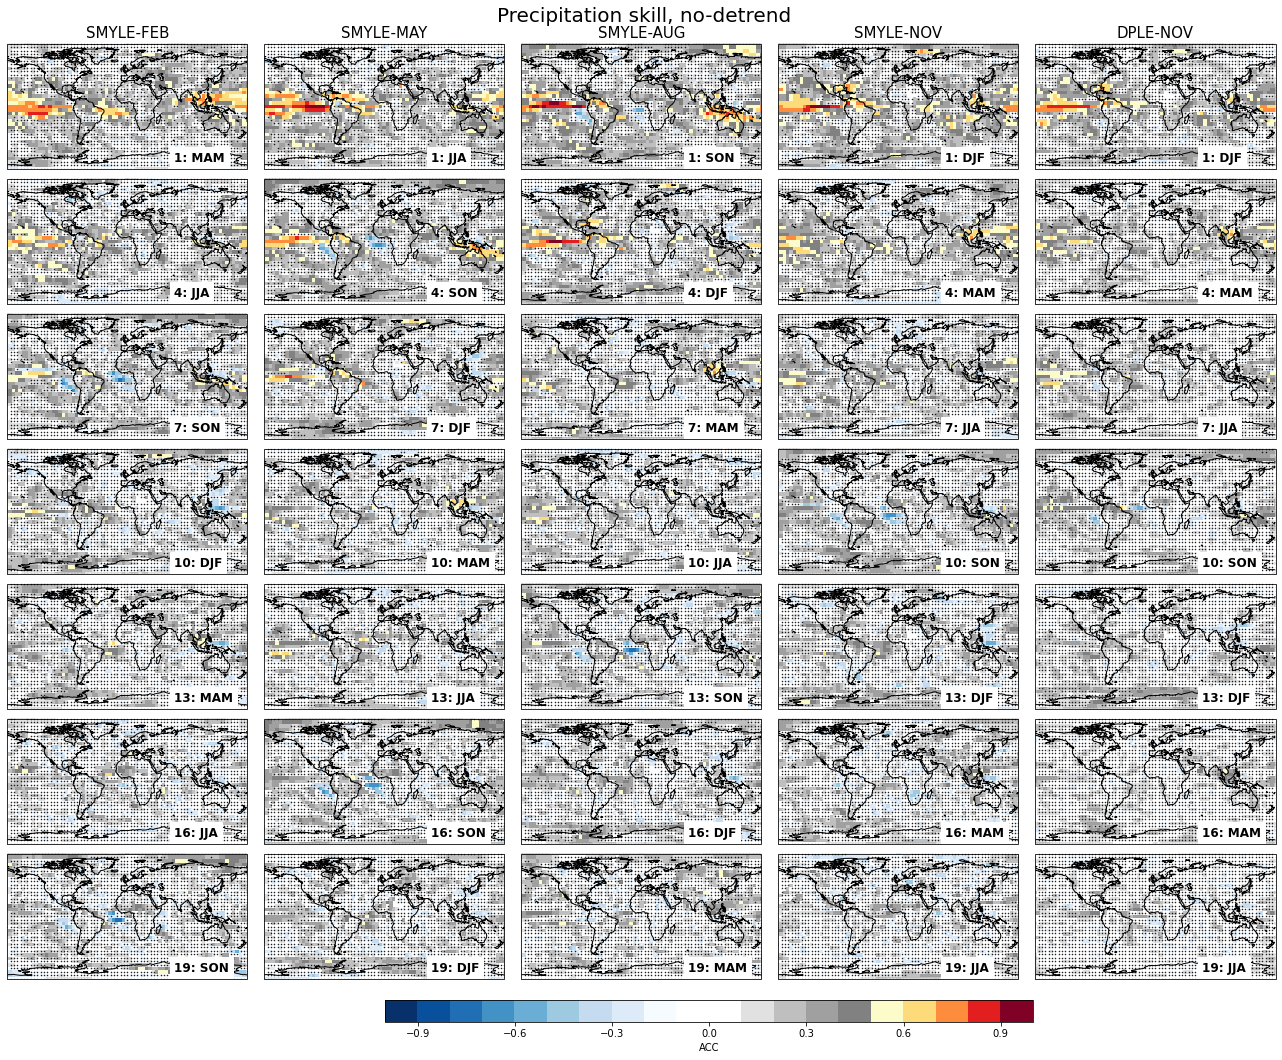

In [25]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_skill.pval.isel(L=i), smyle05_skill.lon, smyle05_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_skill.pval.isel(L=i), smyle08_skill.lon, smyle08_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_skill.pval.isel(L=i), smyle11_skill.lon, smyle11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_skill.pval.isel(L=i), dple11_skill.lon, dple11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Precipitation skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig02_PRE_ACC_nodetrend.png')

In [26]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_skill['corr'] = dple11_skill.corr.where(dple11_skill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 3.86 s, sys: 64.8 ms, total: 3.93 s
Wall time: 4.1 s


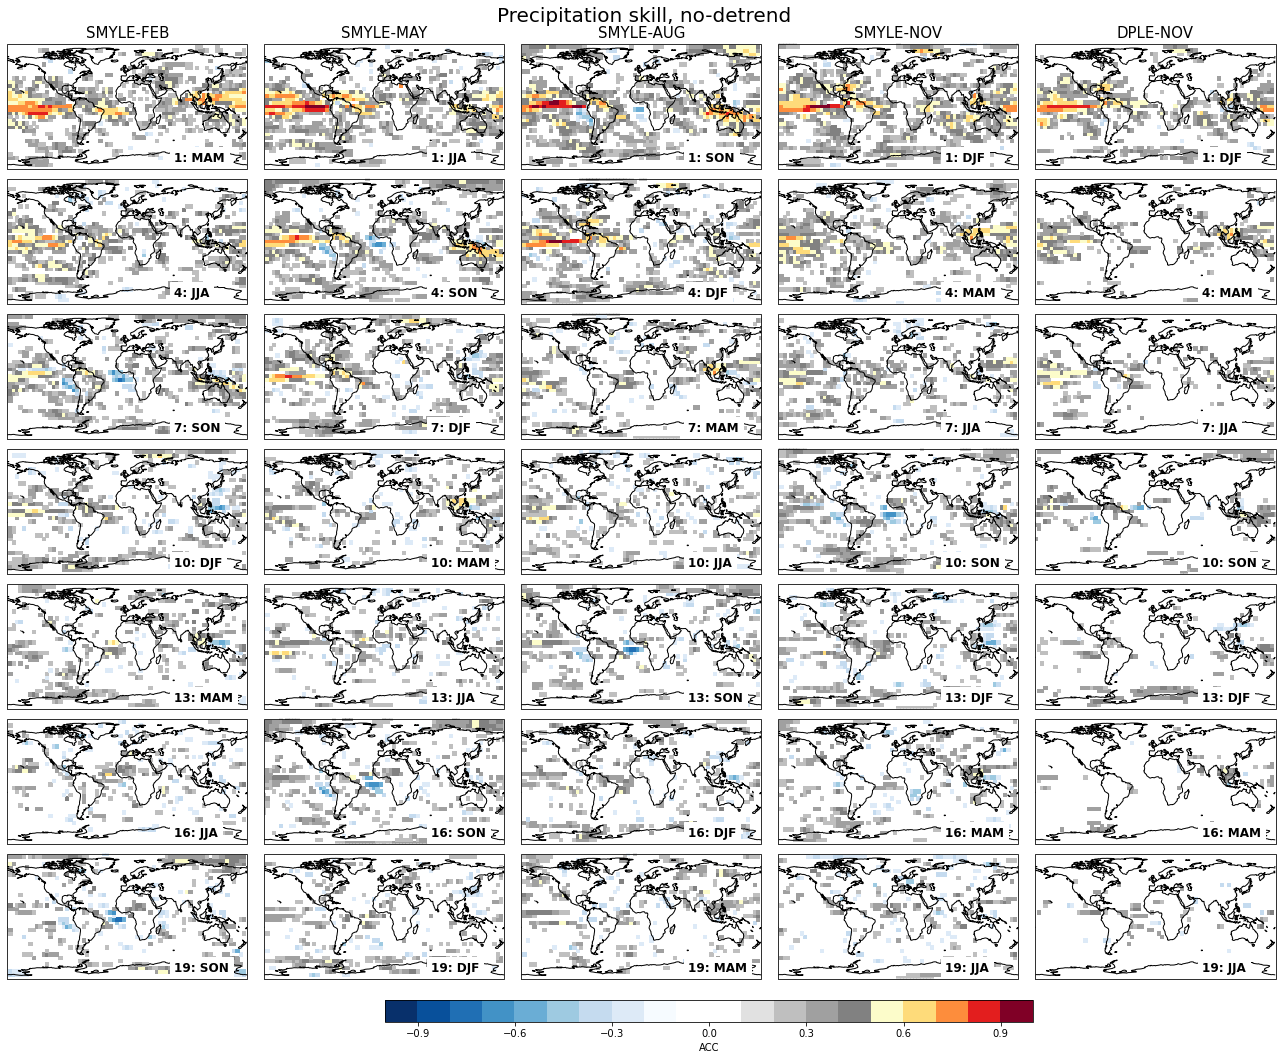

In [27]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Precipitation skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig02_PRE_ACC_nodetrend.png')

### Test Significance Hatching using correlation p-values

CPU times: user 295 ms, sys: 0 ns, total: 295 ms
Wall time: 296 ms


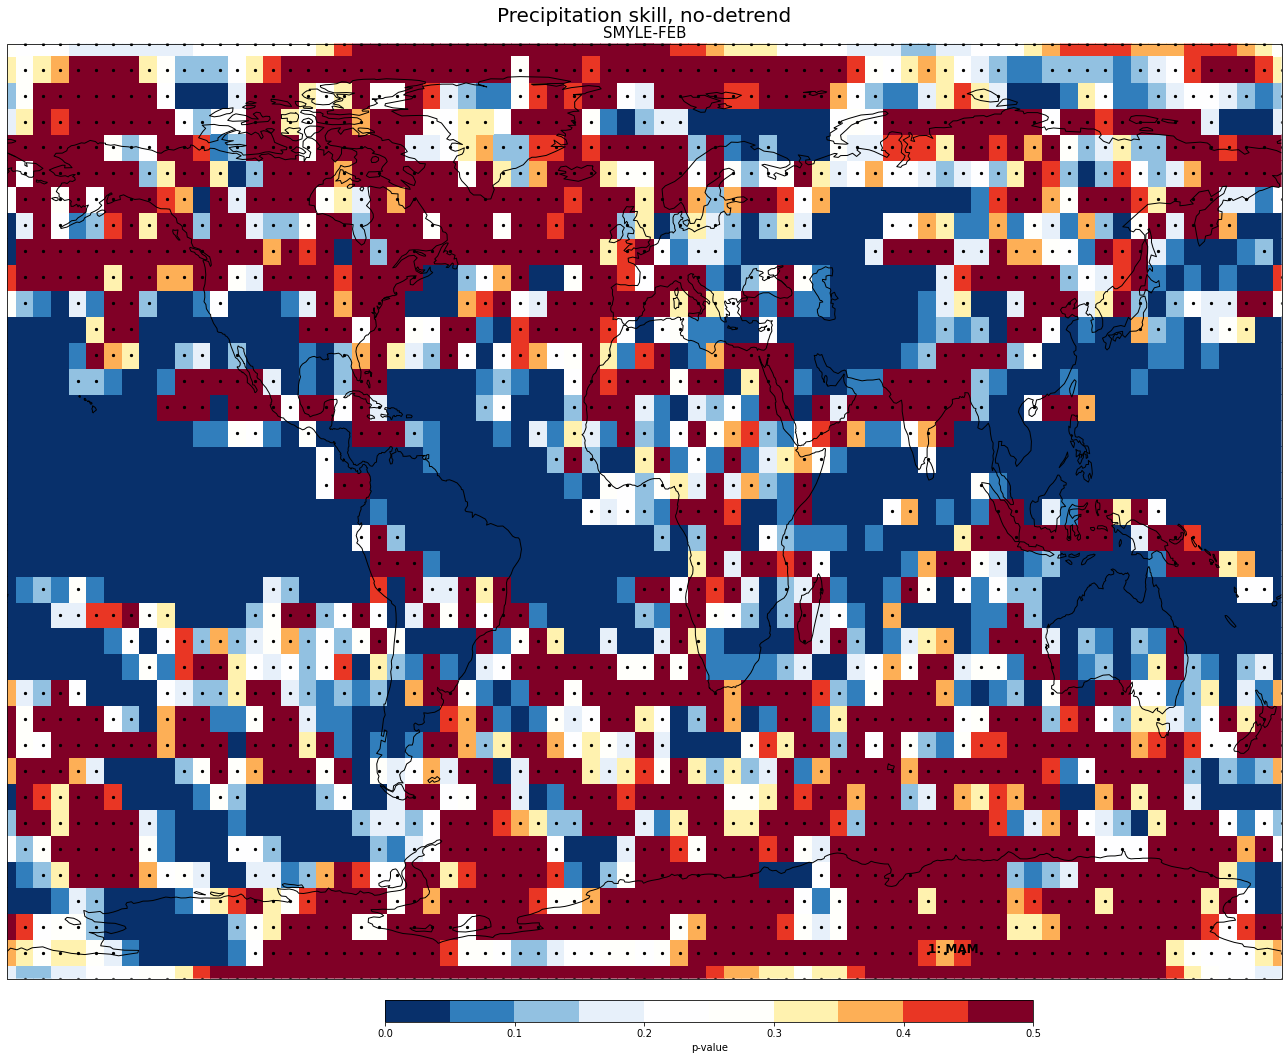

In [28]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=20,marker=".")
    ldstr = str(i+1) + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Precipitation skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [28]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stat.leadtime_skill_seas_resamp(dple11_anom,dple11_seas.time,crujra,100,20,detrend=True)

CPU times: user 3min 32s, sys: 3.25 s, total: 3min 35s
Wall time: 4min 29s


In [29]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_seas.time,crujra,detrend=True)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_seas.time,crujra,detrend=True)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_seas.time,crujra,detrend=True)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_seas.time,crujra,detrend=True)

CPU times: user 9.21 s, sys: 167 ms, total: 9.38 s
Wall time: 10 s


In [30]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_skill['corr'] = dple11_skill.corr.where(dple11_skill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 2.92 s, sys: 64 ms, total: 2.98 s
Wall time: 3.11 s


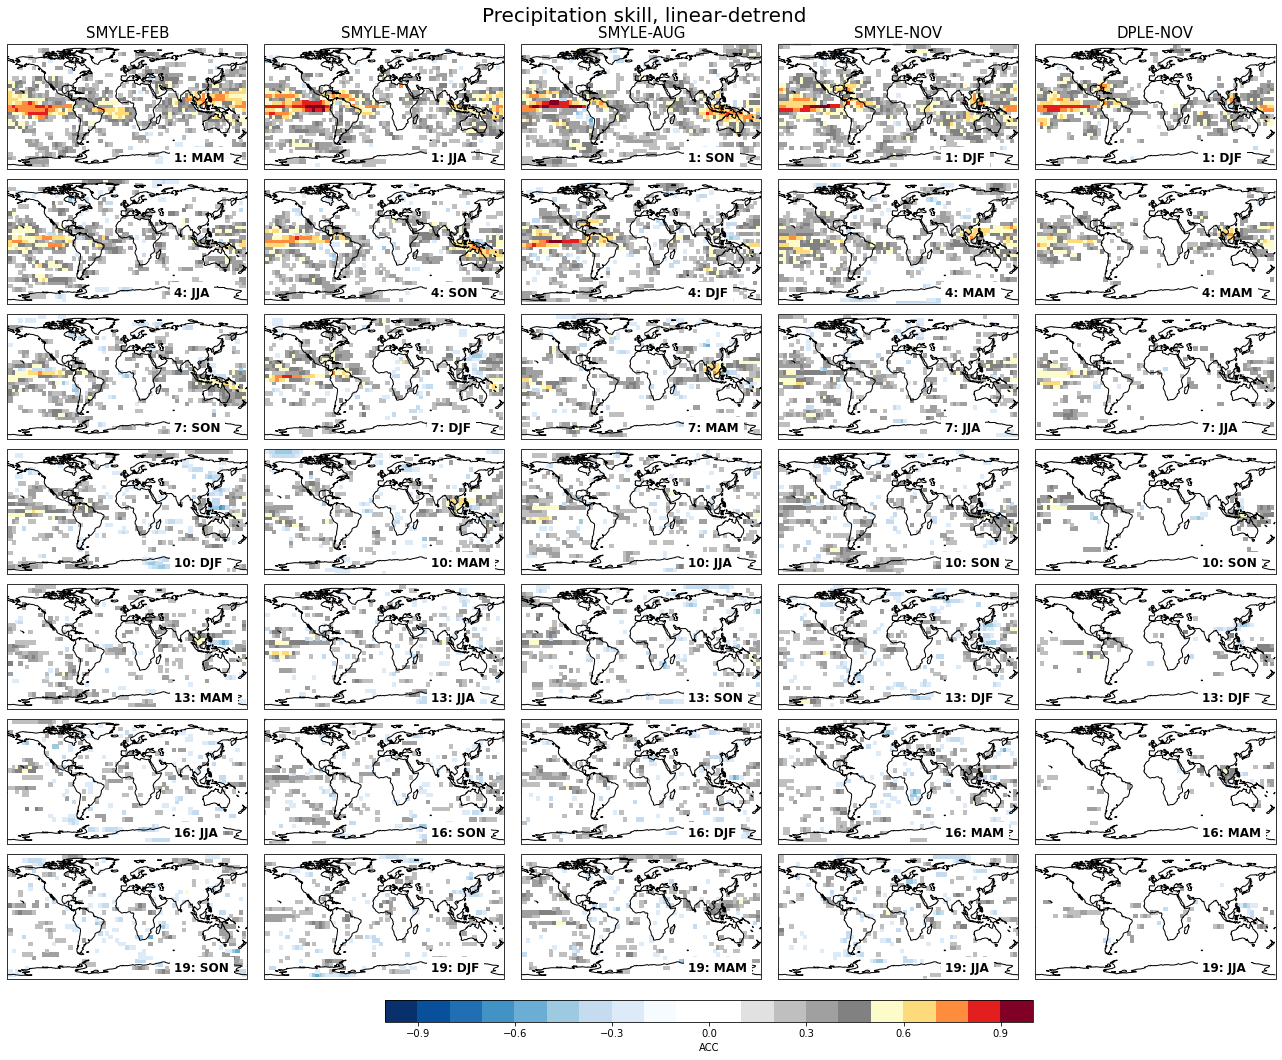

In [31]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Precipitation skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig02_PRE_ACC_lineardetrend.png')

### Look at subsampled skill maps

In [32]:
# This is a list of years for which observed Nino3.4 DJF standardized anomalies exceed +/- 1 std dev. See
# SMYLE-analysis/notebooks/PaperFigs/SMYLEvsDPLE_GlobMaps_SAT.ipynb.
keepyears = np.array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999, 2000, 2008, 2010, 2011, 2016])

In [33]:
%%time
keep11 = (keepyears-1)
keep02 = keepyears
keep05 = keepyears
keep08 = (keepyears-1)
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom.sel(Y=keep11),smyle11_seas.time.sel(Y=keep11),crujra,detrend=True)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom.sel(Y=keep02),smyle02_seas.time.sel(Y=keep02),crujra,detrend=True)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom.sel(Y=keep05),smyle05_seas.time.sel(Y=keep05),crujra,detrend=True)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom.sel(Y=keep08),smyle08_seas.time.sel(Y=keep08),crujra,detrend=True)

CPU times: user 7.41 s, sys: 103 ms, total: 7.51 s
Wall time: 7.85 s


In [34]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stat.leadtime_skill_seas_resamp(dple11_anom.sel(Y=keep11),dple11_seas.time.sel(Y=keep11),crujra,100,20,detrend=True)

CPU times: user 3min 27s, sys: 2.4 s, total: 3min 29s
Wall time: 4min 17s


In [35]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_skill['corr'] = dple11_skill.corr.where(dple11_skill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 3.49 s, sys: 107 ms, total: 3.6 s
Wall time: 3.74 s


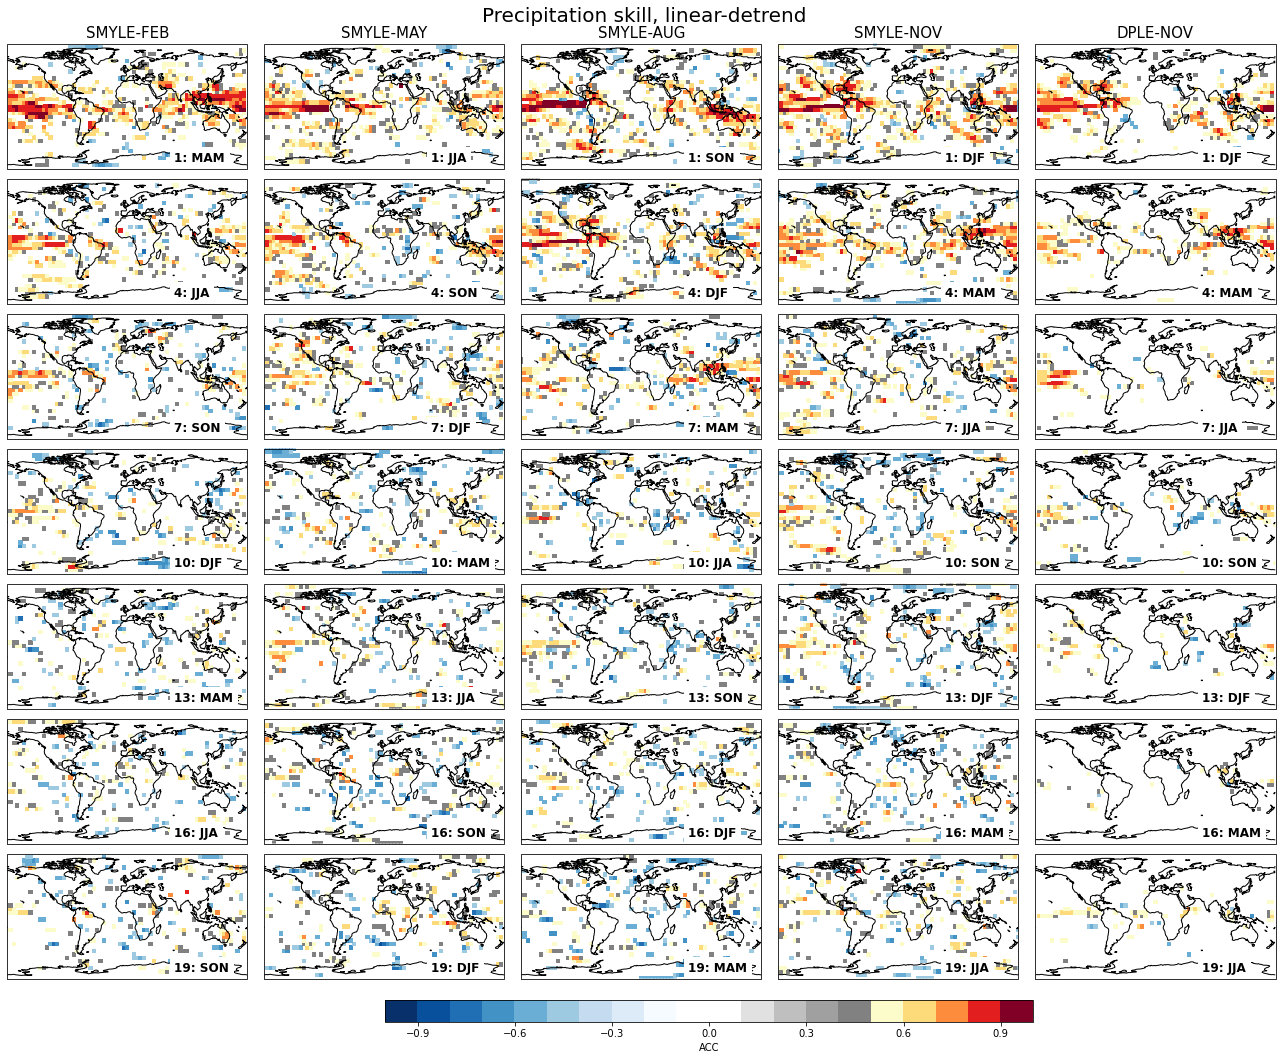

In [36]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Precipitation skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig02_PRE_ACC_lineardetrend_subsamp.png')